<h2 style='color:blue'>Actividad 1</h2> 

1. Cargar el conjunto de datos de alguna de las señales de VDA que se ofrecen a continuación y graficarlo.
2. Entrenar diferentes modelos de Sugeno con todos ellos, variando la cantidad de reglas R (O el parámetro de radio de vecindad del clustering sustractivo, si corresponde). Graficar el error cuadrático medio (MSE) vs. R.
3. Elegir uno de los modelos según la mejor relación entre R y el MSE obtenido.
   Sobremuestrear la señal, barriendo la variable de entrada para tener muchos más valores de muestras que con los datos     originales y utilizando el modelo de Sugeno seleccionado.
4. Presentar todos los resultados y análisis en un documento (PDF o DOCX) y adjuntarlo. Puede presentarse un documento cada dos personas como máximo.

Alumno: Tomas Matarazzo

Nota: Las señales de Variación de Diámetro Arterial fueron muestreadas con una frecuencia de 400 Hz. Es posible graduar así un eje temporal en segundos. El intervalo entre muestras sería de 1/400 s = 2.5ms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Consigna 1

(151, 1)


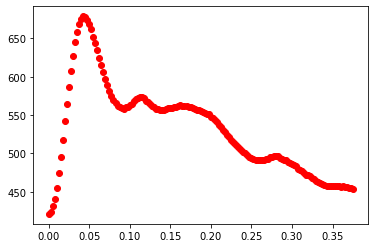

In [7]:
data = pd.read_csv('samplesVDA1.txt', sep=" ", header=None)
data.to_numpy()
from sklearn.model_selection import train_test_split

'''Nota: Las señales de Variación de Diámetro Arterial fueron muestreadas con una frecuencia de 400 Hz. 
Es posible graduar así un eje temporal en segundos. El intervalo entre muestras sería de 1/400 s = 2.5ms.
Tenemos en cuenta esto para graficar el eje x.
'''
N , features = data.shape
print(data.shape)
x = []
x1 = [ n * 1/400 for n in range(N)]

x1 =np.array(x1)
x1 = x1.reshape(-1,1)
data = np.concatenate( (x1,data) , axis = 1)
#plt.scatter(data[:,0],data[:,1], color = 'blue')

plt.scatter(data[:,0],data[:,1], color = 'red')


#### Entrenamos sugeno , para clustering utilizamos Fuzzy C Means

In [3]:
from sklearn.preprocessing import MinMaxScaler
import time
from fcmeans import FCM

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii, n_reglas):
        my_model = FCM(n_clusters=n_reglas) 
        my_model.fit(data) 
        cluster_center = my_model.centers
        labels = my_model.predict(data)
        start_time = time.time()
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()
        


#### Consigna 2
Graficamos R vs MSE

#### Consigna 3 
Se deduce a partir del grafico que la cantidad de reglas para que el modelo generalice de la mejor manera son 11.



Text(0, 0.5, 'MSE')

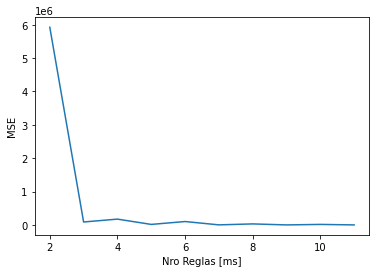

In [17]:
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

data_x = data[:,0]
data_y = data[:,1]

data = np.vstack((data_x, data_y)).T
fis2 = fis()
errores = []
for i in range(2,12):
    fis2.genfis(data, 1.1 ,i)
    r = fis2.evalfis(np.vstack(data_x))
    error = (data[:,1] - r)**2
    mse = error.sum()
    errores.append(mse)

plt.plot(np.arange(2,12, 1), errores)
plt.xlabel('Nro Reglas [ms]')
plt.ylabel('MSE')
# plt.plot(data_x, data_y ,c = 'skyblue')
# plt.plot(data_x , r, c = 'salmon')
# plt.xlabel('tiempo [ms]')
# plt.ylabel('Variacion de diametro arterial')

#### Consigna 4
Para sobremuestrear creo un nuevo conjunto de datos dentro del rango de 0 a 0.375 pero con una mayor cantidad de muestras

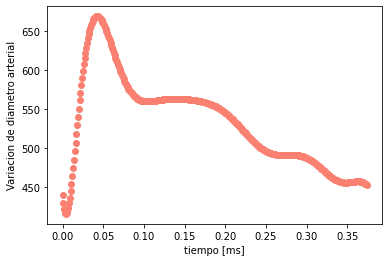

In [5]:
fis2.genfis(data, 1.1 ,11)
r = fis2.evalfis(np.vstack(data_x))


sobremuestreo = np.vstack(np.arange(0, 0.375 , 0.001))
r = fis2.evalfis(sobremuestreo)

plt.scatter(sobremuestreo , r, c = 'salmon')
plt.xlabel('tiempo [ms]')
plt.ylabel('Variacion de diametro arterial')
plt.show()